This is a place to test things and mess around.

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as scop

In [32]:
trainset = pd.read_csv('train.csv', index_col = 'Id')

In [33]:
trainset.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [34]:
nullratio = trainset.isnull().sum() / trainset.shape[0]

In [35]:
nullratio[nullratio.values > 0]

LotFrontage     0.177397
Alley           0.937671
MasVnrType      0.005479
MasVnrArea      0.005479
BsmtQual        0.025342
BsmtCond        0.025342
BsmtExposure    0.026027
BsmtFinType1    0.025342
BsmtFinType2    0.026027
Electrical      0.000685
FireplaceQu     0.472603
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
PoolQC          0.995205
Fence           0.807534
MiscFeature     0.963014
dtype: float64

Lots of missing records. Some features like Alley has a lot of NaN that indicates no alley access so the NaNs are not missing information. NaNs like those will be filled with appropriate values in digitizing the features. There are a few features with real missing information, like LotFrontage or Eletrical. Those NaN needs to be filled or those features can't be used. 

A lot of features consists of discrete data type, like MSSubClass, where the values may needs to be remapped to improve the model. Those features needs to be analyzed and possibly mapped into different features to be used in the model.

Below I examine each feature and process them to be ready for modeling.

In [36]:
aggvals = {'mean', 'std', 'count'}
a = trainset.groupby('MSSubClass').SalePrice.agg(aggvals)
a

,std,count,mean
MSSubClass,,,
20,78782.189961,536,185224
30,24857.110069,69,95829
40,75747.799744,4,156125
45,20231.723876,12,108591
50,54851.983702,144,143302
60,86579.909962,299,239948
70,58206.545757,60,166772
75,100556.762572,16,192437
80,38197.808759,58,169736


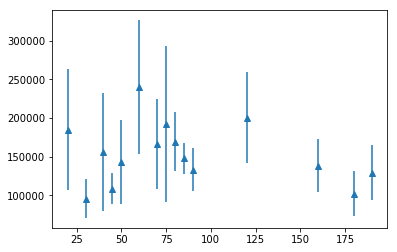

In [37]:
plt.errorbar(a.index, a['mean'], a['std'], linestyle = 'None', marker = '^')
plt.show()

Certain dwelling types have a very well defined narrow band while a few, like class 75: 2-1/2 story all ages have a relatively wide range of prices.

In [38]:
a = trainset.groupby('MSZoning').SalePrice.agg(aggvals)
a

,std,count,mean
MSZoning,,,
C (all),33791.092021,10,74528
FV,52369.662067,65,214014
RH,35714.118427,16,131558
RL,80766.341319,1151,191004
RM,48521.689830,218,126316


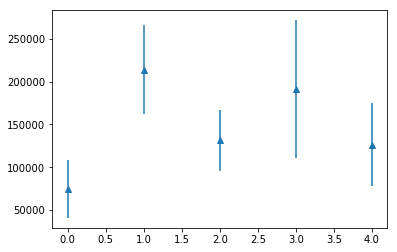

In [39]:
plt.errorbar(range(0, a.shape[0]), a['mean'], a['std'], linestyle = 'None', marker = '^')
plt.show()

Most of the records are in RL: residential low density. The few that are in other categories like Commercial have a relatively narrow range of distribution. It suggests that the feature on its own is not going to be useful in separating most of the houses apart. However, it can be useful when combined with other features.

In [49]:
uzone = trainset.MSZoning.unique()
uzonemap = dict(zip(uzone, range(0, uzone.size)))

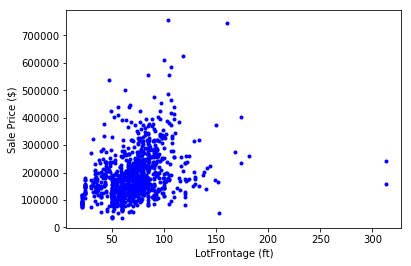

In [43]:
plt.plot(trainset.LotFrontage, trainset.SalePrice, '.b')
plt.xlabel('LotFrontage (ft)')
plt.ylabel('Sale Price ($)')
plt.show()

In [42]:
trainset[['LotFrontage', 'SalePrice']].corr()

,LotFrontage,SalePrice
LotFrontage,1.000000,0.351799
SalePrice,0.351799,1.000000


The linear feet of street connected to property has a decent correlation coefficient with the sales price. About 18% of the data in the training set is missing this information. The plot above suggests there might be at least two sub trends, one with sale price increasing much faster with LotFrontage and the other with a gentler slope between the two. This observation suggests that combining features could improve correlation to sales price. In this case, if we can find a feature that normalized the two trends and collapses them into one the correlation between the normalized LotFrontage and sales price can be greatly improved. So far it seems the subclass or the zoning are not the normalizing factor.

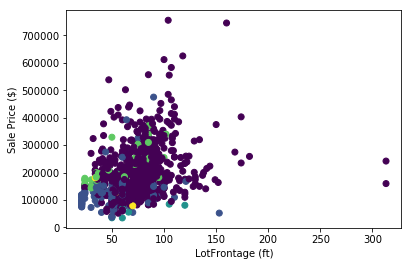

In [51]:
plt.scatter(trainset.LotFrontage, trainset.SalePrice, c = trainset.MSZoning.map(uzonemap))
plt.xlabel('LotFrontage (ft)')
plt.ylabel('Sale Price ($)')
plt.show()

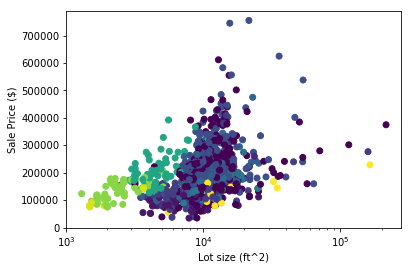

In [67]:
fig = plt.figure
ax = plt.gca()
ax.scatter(trainset.LotArea, trainset.SalePrice, c = trainset.MSSubClass)
ax.set_xscale('log')
plt.xlabel('Lot size (ft^2)')
plt.ylabel('Sale Price ($)')
plt.show()

The lot size has a wide range in the database, therefore it is more appropriate to use its logarithmic value to correlate to the sales price. The figure above shows that depending on the type of dwelling (MSSubClass), the price has different trends with $log(LotSize)$.

With the few features I examin